## Setup

In [ ]:
!pip install "tensorflow-text==2.8.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np

import typing
from typing import Any, Tuple
import os

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
!gdown --id 1fvjtZxFxls4KSQtoplP_Xoq-5OsEM7on
!gdown --id 1zwSQE4s_vrY0q7dQWAvcBvLC6wfv3OBx

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fvjtZxFxls4KSQtoplP_Xoq-5OsEM7on
To: /content/food_en_dict.txt
100% 336k/336k [00:00<00:00, 118MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1zwSQE4s_vrY0q7dQWAvcBvLC6wfv3OBx
To: /content/food_vn_dict.txt
100% 334k/334k [00:00<00:00, 85.5MB/s]


In [ ]:
def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, encoding="utf-8", mode='rt') as f:
        data = f.read()

    return data.split('\n')

In [ ]:
targ = load_data("/content/food_en_dict.txt")
inp = load_data("/content/food_vn_dict.txt")

In [ ]:
print(inp[-1])

### Create a tf.data dataset

In [ ]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 512

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [ ]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'sashimi tr\xe1\xbb\xa9ng t\xc3\xb4m'
 b'c\xc6\xa1m chi\xc3\xaan mu\xe1\xbb\x91i \xe1\xbb\x9bt'
 b'\xe1\xba\xbfch + x\xc3\xb4i'
 b'b\xc3\xb2 cu\xe1\xbb\x99n kim ch\xc3\xa2m' b'udon t\xc3\xb4m tempura'], shape=(5,), dtype=string)

tf.Tensor(
[b'ebiko masago' b'fried rice salt chilly' b'frog + sticky rice'
 b'beef and enoki mushroom rolls' b'shrimp tempura udon'], shape=(5,), dtype=string)


### Text preprocessing

In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


#### Text Vectorization

In [ ]:
max_vocab_size = 5000

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [ ]:
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', 'ca', 'tra', 'bo', 'sua', 'nuong', 'chien']

That's the Spanish `TextVectorization` layer, now build and `.adapt()` the English one:

In [ ]:
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 '[START]',
 '[END]',
 'with',
 'fried',
 'tea',
 'grilled',
 'rice',
 'milk']

Now these layers can convert a batch of strings into a batch of token IDs:

In [ ]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[  2, 102,  15,  12,   3,   0,   0,   0,   0,   0],
       [  2,  13,   9,  20,  42,   3,   0,   0,   0,   0],
       [  2,  76, 274,   3,   0,   0,   0,   0,   0,   0]])>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [ ]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] sashimi trung tom [END]        '

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

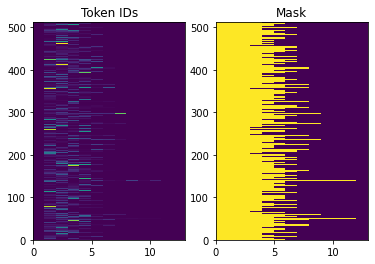

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

## The encoder/decoder model

The following diagram shows an overview of the model. At each time-step the decoder's output is combined with a weighted sum over the encoded input, to predict the next word. The diagram and formulas are from [Luong's paper](https://arxiv.org/abs/1508.04025v5).

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">


Before getting into it define a few constants for the model:

In [ ]:
embedding_dim = 256
units = 1024

###  encoder



In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

Here is how it fits together so far:

In [ ]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (512,)
Input batch tokens, shape (batch, s): (512, 13)
Encoder output, shape (batch, s, units): (512, 13, 1024)
Encoder state, shape (batch, units): (512, 1024)


### The attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

### Test the Attention layer

Create a `BahdanauAttention` layer:

In [ ]:
attention_layer = BahdanauAttention(units)

In [ ]:
(example_tokens != 0).shape

TensorShape([512, 13])

In [ ]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (512, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (512, 2, 13)


Text(0.5, 1.0, 'Mask')

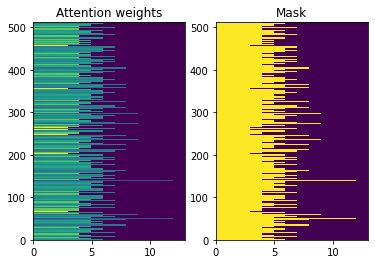

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')


Because of the small-random initialization the attention weights are all close to `1/(sequence_length)`. If you zoom in on the weights for a single sequence, you can see that there is some _small_ variation that the model can learn to expand, and exploit.

In [ ]:
attention_weights.shape

TensorShape([512, 2, 13])

In [ ]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

###  decoder




Here is the `Decoder` class and its initializer. The initializer creates all the necessary layers.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

The `call` method for this layer takes and returns multiple tensors. Organize those into simple container classes:

In [ ]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

Here is the implementation of the `call` method:

In [ ]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [ ]:
Decoder.call = call

In [ ]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [ ]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [ ]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (512, 1, 3051)
state shape: (batch_size, dec_units) (512, 1024)


Sample a token according to the logits:

In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

Decode the token as the first word of the output:

In [ ]:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['makerel'],
       ['champagne'],
       ['noddle'],
       ['vinegared'],
       ['miserable']], dtype='<U31')

In [ ]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [ ]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['dish'],
       ['highball'],
       ['pinnata'],
       ['tokbokki'],
       ['mantis']], dtype='<U31')

## Training

Now that you have all the model components, it's time to start training the model. You'll need:

- A loss function and optimizer to perform the optimization.
- A training step function defining how to update the model for each input/target batch.
- A training loop to drive the training and save checkpoints.

### Define the loss function

In [ ]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

### Implement the training step

In [ ]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor,
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [ ]:
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [ ]:
TrainTranslator._preprocess = _preprocess

In [ ]:
def _train_step(self, inputs):
  input_text, target_text = inputs

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [ ]:
TrainTranslator._train_step = _train_step

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [ ]:
TrainTranslator._loop_step = _loop_step

In [ ]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

Test out the `train_step`. For a text model like this the loss should start near:

In [ ]:
np.log(output_text_processor.vocabulary_size())

8.02322468471667

In [ ]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.526005>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.4863234>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.374054>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.97208>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.745561>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=8.73193>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.553021>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.269989>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.7417717>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.813118>}

CPU times: user 5.15 s, sys: 151 ms, total: 5.3 s
Wall time: 6.11 s


While it's easier to debug without a `tf.function` it does give a performance boost. So now that the `_train_step` method is working, try the `tf.function`-wrapped `_tf_train_step`, to maximize performance while training:

In [ ]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [ ]:
TrainTranslator._tf_train_step = _tf_train_step

In [ ]:
translator.use_tf_function = True

The first call will be slow, because it traces the function.

In [ ]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.6645026>}

But after that it's usually 2-3x faster than the eager `train_step` method:

In [ ]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.4523587>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.287389>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1637926>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.041836>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.950547>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.950726>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.97709>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.9448204>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8725815>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.8098836>}

CPU times: user 3.99 s, sys: 280 ms, total: 4.27 s
Wall time: 3.62 s


A good test of a new model is to see that it can overfit a single batch of input. Try it, the loss should quickly go to zero:

....................................................................................................


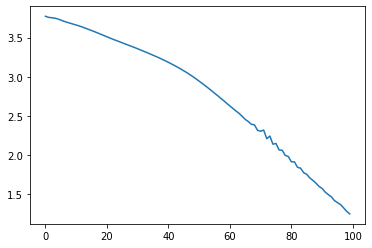

In [ ]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

Now that you're confident that the training step is working, build a fresh copy of the model to train from scratch:

In [ ]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### Train the model

While there's nothing wrong with writing your own custom training loop, implementing the `Model.train_step` method, as in the previous section, allows you to run `Model.fit` and avoid rewriting all that boiler-plate code.

This tutorial only trains for a couple of epochs, so use a `callbacks.Callback` to collect the history of batch losses, for plotting:

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(dataset, epochs=200,
                     callbacks=[batch_loss])

Epoch 1/200
30/30 [==============================] - 19s 431ms/step - batch_loss: 4.9594
Epoch 2/200
30/30 [==============================] - 13s 445ms/step - batch_loss: 3.9568
Epoch 3/200
30/30 [==============================] - 13s 450ms/step - batch_loss: 3.6906
Epoch 4/200
30/30 [==============================] - 13s 435ms/step - batch_loss: 3.3044
Epoch 5/200
30/30 [==============================] - 13s 423ms/step - batch_loss: 2.9405
Epoch 6/200
30/30 [==============================] - 13s 435ms/step - batch_loss: 2.5889
Epoch 7/200
30/30 [==============================] - 13s 439ms/step - batch_loss: 2.2127
Epoch 8/200
30/30 [==============================] - 13s 438ms/step - batch_loss: 1.8747
Epoch 9/200
30/30 [==============================] - 13s 449ms/step - batch_loss: 1.6074
Epoch 10/200
30/30 [==============================] - 13s 448ms/step - batch_loss: 1.3938
Epoch 11/200
30/30 [==============================] - 13s 415ms/step - batch_loss: 1.2131
Epoch 12/200
30/30 

Text(0, 0.5, 'CE/token')

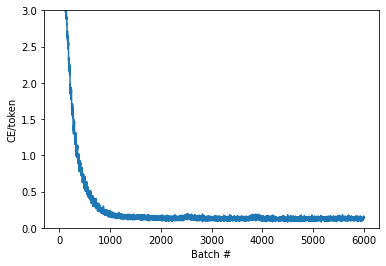

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

The visible jumps in the plot are at the epoch boundaries.

## Translate


In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Convert token IDs to text

In [ ]:
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

In [ ]:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

array([b'land fingersnails', b'babylonia healing', b'ocean flavour',
       b'ocean lai', b'vegetable mask'], dtype=object)

### Sample from the decoder's predictions

This function takes the decoder's logit outputs and samples token IDs from that distribution:

In [ ]:
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else:
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)
  
  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [ ]:
Translator.sample = sample

Test run this function on some random inputs:

In [ ]:
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[ 771],
       [2965],
       [ 470],
       [ 955],
       [2422]])>

### Implement the translation loop


In [ ]:
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))
    
    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}


In [ ]:
Translator.translate = translate_unrolled


Run it on a simple input:

In [ ]:
%%time
input_text = tf.constant(inp[:100])

result = translator.translate(
    input_text = input_text)

for i in range(100):
  print(result['text'][i].numpy().decode())


combo
combo
combo
soju
vodka
tiger can
tiger bottle
crystal tiger can
crystal tiger can
coca
sprite
water
red bull
quy nhon beer
bivina beer
strong bow
sauteed water spinach with garlic
sauteed spinach with garlic
sauteed borecole with garlic
okra with garlic
french fries
fried frog skin with sauce
crispy fried frog skin
roasted frog skin with salt
beans fried
jellyfish with fine shrimp sauce
stir fried baby corn with scallion
stir fried corn with shrimp
fried milk sentinel crab with fish sauce
fried milk sentinel crab with salt
vietnamese crispy spring shirmp roll
pork ears salad
jellyfish salad
seafood salad
chicken feet without bone
beef salad
rare beef with lemons
octopus salad
shrimp salad
german sausage
baked oysters
grilled eggplant
grilled fish ball beef ball shrimp ball
grilled dumplings
grilled pigs guts
grilled chicken gizzard
grilled squid
grilled shrimp
grilled octopus
baked ribs bbq
baked bacon
grilled frog
grilled american short plate
short plate roll mushroom
short plat

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

Run the `tf.function` once to compile it:

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 19.4 s, sys: 438 ms, total: 19.9 s
Wall time: 19.8 s


In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

combo
combo

CPU times: user 167 ms, sys: 19.2 ms, total: 187 ms
Wall time: 234 ms


In [ ]:
Translator.translate = translate_symbolic

But when you wrap it in a `tf.function` you'll notice two differences.

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

First: Graph creation is much faster (~10x), since it doesn't create `max_iterations` copies of the model.

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

CPU times: user 1.21 s, sys: 21.6 ms, total: 1.23 s
Wall time: 1.22 s


Second: The compiled function is much faster on small inputs (5x on this example), because it can break out of the loop.

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

combo
combo

CPU times: user 55.8 ms, sys: 2.45 ms, total: 58.3 ms
Wall time: 58.2 ms


## Export

In [ ]:
tf.saved_model.save(translator, '/content/drive/MyDrive/translator',
                    signatures={'serving_default': translator.tf_translate})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
reloaded = tf.saved_model.load('translator')
result = reloaded.tf_translate(three_input_text)

In [ ]:
%%time
result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
  print(tr.numpy().decode())

print()

maguro style
black tiger shrimp with special sauce
goat brain

CPU times: user 40.1 ms, sys: 4.38 ms, total: 44.5 ms
Wall time: 32.8 ms
